# Decoding Board from Data

In [422]:
#necessary imports
import pandas
import numpy as np
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex = True)
import math

import matplotlib.pyplot as plt
%matplotlib inline

#retrieve vector data from gamestate
inputGamestate = np.array(pandas.read_table("nineFullData(2)_Validated.txt", delim_whitespace = True, header = None))

#Decoding Board From Data
board_size = 9 * 9
board_length = int(math.sqrt(board_size))
boardState = np.zeros((len(inputGamestate), (board_size)))

In [423]:
boardState.shape #Number of board states present in the data/size of board

In [424]:
#Encoding board states to 1D array per data entry

index_of_board = 0
for row in inputGamestate:
    index_of_token = 0
    for item in row:
        if index_of_token < board_size*3:
            tile = inputGamestate[index_of_board][index_of_token:index_of_token + 3]
            if(tile[2] == 1):
                boardState[index_of_board][int(index_of_token/3)] = 0 #Tile is empty
            elif(tile[1] == 1):
                boardState[index_of_board][int(index_of_token/3)] = -1 #Black occupies this tile
            elif(tile[0] == 1):
                boardState[index_of_board][int(index_of_token/3)] = 1 #White occupies this tile
            index_of_token+=3
    index_of_board+=1

In [426]:
boardState[:4] #Examples of board changing with moves that are made

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
   

# Data Categorization and Assignment

In [427]:
X = boardState[:, 0:81]

train_data = X.shape[0]

#Coordinate of move made to achieve board state (bottom left of the board being 0, 0)
#coordinate = inputGamestate[:, 243:245]

#Legality checker for the move
#legal = inputGamestate[:, 245]

#Black or white to move from this position(-1 or 1 respectively)
#whoseTurn = inputGamestate[:, 246]

#Who won from this position (-1 or 1 respectively, 0 for play continues)
#whoWon = inputGamestate[:, 247]

#Move to be made from this position
playersMove = inputGamestate[:, 248]

#Input
#X = inputGamestate[:, :248]

#Creating 81 categories based on every spot on the board, 1 representing the move to be made
Y = keras.utils.to_categorical(playersMove, len(np.unique(playersMove)))

training_samples = int(0.9 * train_data)
X_train, X_test = X[:training_samples], X[training_samples:]
Y_train, Y_test = Y[:training_samples], Y[training_samples:]

In [428]:
X[0].shape

# Building the Model

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 9, 9, 1)           0         
_________________________________________________________________
zero_padding2d_59 (ZeroPaddi (None, 9, 15, 7)          0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 9, 15, 48)         16512     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 5, 48)          0         
_________________________________________________________________
zero_padding2d_60 (ZeroPaddi (None, 3, 11, 54)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 3, 11, 48)         64848     
_________________________________________________________________
dropout_51 (Dropout)         (None, 3, 11, 48)       

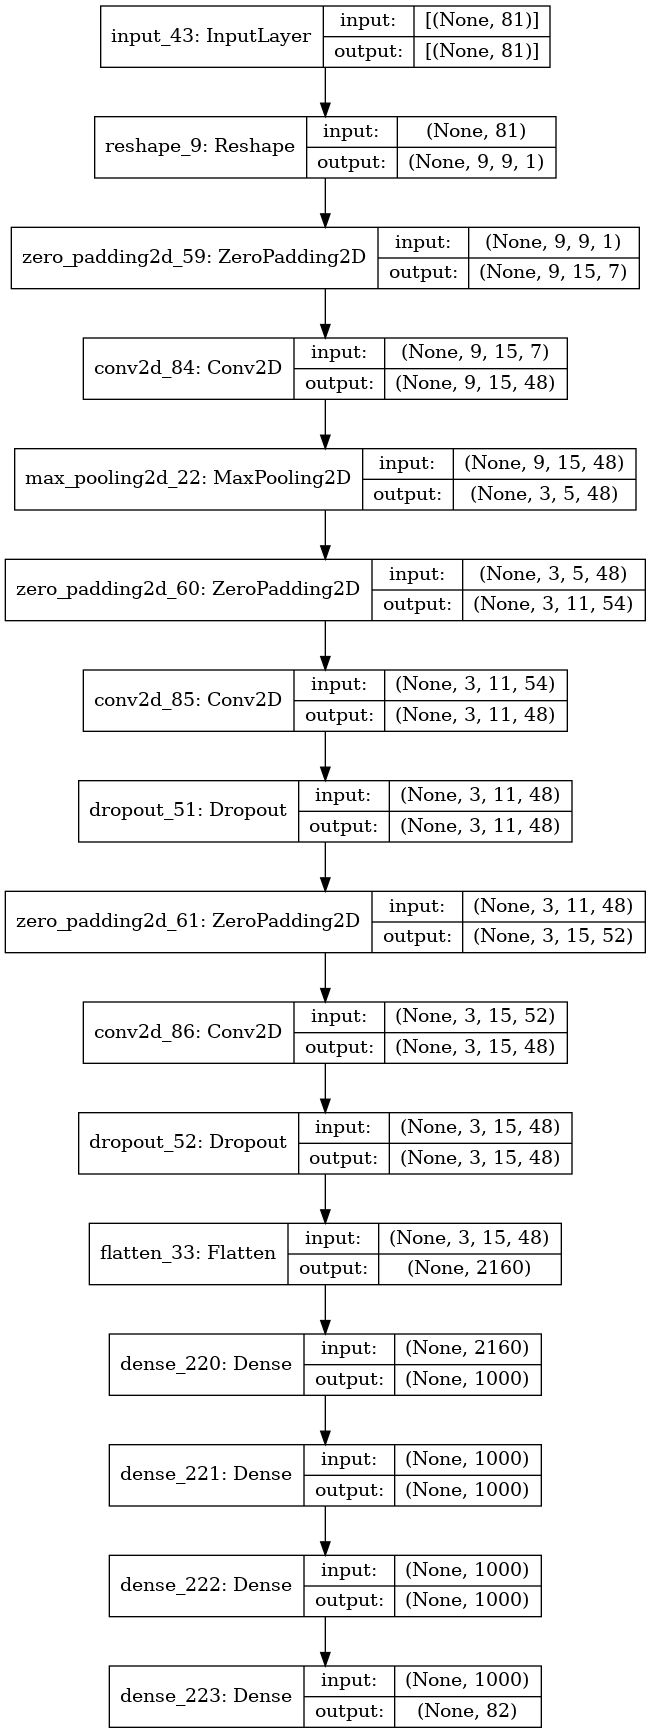

In [429]:
#defining input shape (board state)
#input_size = X.shape[1]

input_shape = X[0].shape
#defining output shape 
#output_size = Y.shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Input(shape = input_shape))
model.add(keras.layers.Reshape((board_length, board_length, 1)))
model.add(keras.layers.ZeroPadding2D(padding = 3, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (7, 7), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(keras.layers.MaxPooling2D(pool_size = (3, 3)))
model.add(keras.layers.ZeroPadding2D(padding = 3, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.ZeroPadding2D(padding = 2, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dense(board_size + 1, activation = 'softmax'))

#hidden1 = keras.layers.Dense(1000, activation = 'relu')(conv2D_1)
#hidden2 = keras.layers.Dense(1000, activation = 'relu')(hidden1)
#hidden3 = keras.layers.Dense(1000, activation = 'relu')(hidden2)
#drop1 = keras.layers.Dropout(0.2)(hidden3)
#hidden4 = keras.layers.Dense(1000, activation = 'relu')(drop1)
#hidden5 = keras.layers.Dense(1000, activation = 'relu')(hidden4)
#output = keras.layers.Dense(82, activation = 'softmax')(hidden5)
#model = Model(inputs = conv2D_1, outputs = output)

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.CategoricalAccuracy()])
model.summary()
keras.utils.plot_model(model, show_shapes = True, expand_nested = True, show_layer_names = True)

#0 if the game ends
#1 - 81
#row major order from top left, bottom right is 81

# Training

In [269]:
#Train the model
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 100, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/100
2828/2828 [==============================] - 251s 88ms/step - loss: 4.0730 - categorical_accuracy: 0.0299 - val_loss: 3.8574 - val_categorical_accuracy: 0.0624
Epoch 2/100
2828/2828 [==============================] - 189s 67ms/step - loss: 3.8185 - categorical_accuracy: 0.0665 - val_loss: 3.6518 - val_categorical_accuracy: 0.0982
Epoch 3/100
2828/2828 [==============================] - 183s 65ms/step - loss: 3.6600 - categorical_accuracy: 0.0933 - val_loss: 3.5570 - val_categorical_accuracy: 0.1121
Epoch 4/100
2828/2828 [==============================] - 195s 69ms/step - loss: 3.5732 - categorical_accuracy: 0.1092 - val_loss: 3.5025 - val_categorical_accuracy: 0.1244
Epoch 5/100
2828/2828 [==============================] - 321s 114ms/step - loss: 3.5133 - categorical_accuracy: 0.1207 - val_loss: 3.4558 - val_categorical_accuracy: 0.1343
Epoch 6/100
2828/2828 [==============================] - 385s 136ms/step - loss: 3.4641 - categorical_accuracy: 0.1298 - val_loss: 3.4341 -

In [ ]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [239]:
model.save_weights('weights.h5')